# Simulating an SIS mixer

- This is a multi-tone simultion (i.e., heterodyne mixing)
    - The input consists of 3 signals
        - a strong local-osciallator at 230 GHz
        - a weak RF signal at 232 GHz 
        - an IF signal
    - The embedding circuit is included
    - The response function is generated from an experimental I-V curve

- This simulation calculates:
    - The pumped I-V curve
    - The mixer's gain

In [1]:
%matplotlib inline

import qmix
import numpy as np
import scipy.constants as sc 
import matplotlib.pyplot as plt

import qmix.misc.terminal
from qmix.misc.terminal import cprint
from qmix.mathfn.misc import slope

## Define junction properties
- These are common parameters that describe the electrical properties of SIS junctions

In [2]:
vgap = 2.7e-3              # gap voltage in [V]
rn = 13.5                  # normal resistance in [ohms]
igap = vgap / rn           # gap current in [A]
fgap = sc.e * vgap / sc.h  # gap frequency in [Hz]

## Define embedding circuit
- The ``EmbeddingCircuit`` class contains all of the information about the embedding circuit. This includes the Thevenin voltage, the Thevening impedance, and the frequency.
- Note: 
   - All of the circuit properties are normalized: 
      - voltages are normalized to the gap voltage (``vgap``), 
      - resistances to the normal resistance (``rn``), 
      - currents to the gap current (``igap = vgap / rn``), and 
      - frequencies to the gap frequency (``fgap``).
   - This example includes the embedding circuit. Each tone/harmonic requires:
      - the embedding voltage (normalized to ``vgap``)
      - the embedding impedance (normalized to ``rn``)
      - the frequency of the fundamental (normalized to ``fgap``)

In [3]:
# simulation parameters
num_f = 3  # number of tones
num_p = 1  # number of harmonics
num_b = (10, 5, 10)  # Bessel function summations limits

# the LO signal
f_lo         = 230e9 / fgap      # frequency in [Hz]
alpha_lo     = 1.2               # junction drive level (normalized value)
impedance_lo = 0.3 - 0.3*1j      # embedding impedance (normalized value)

# the RF signal
f_rf         = 232e9 / fgap      # frequency in [Hz]
alpha_rf     = 0.012             # junction drive level (normalized value)
impedance_rf = 0.3 - 0.3*1j      # embedding impedance (normalized value)

# the IF signal
f_if         = 2e9 / fgap        # frequency in [Hz]
impedance_if = 1.                # embedding impedance (normalized value)

# build embedding circuit
cct = qmix.circuit.EmbeddingCircuit(num_f, num_p, fgap=fgap, vgap=vgap, rn=rn, vb_max=1.5)
cct.comment[1][1] = 'LO'
cct.comment[2][1] = 'USB'
cct.comment[3][1] = 'IF'
cct.vph[1] = f_lo
cct.vph[2] = f_rf
cct.vph[3] = f_if
cct.vt[1, 1] = cct.vph[1] * alpha_lo
cct.vt[2, 1] = cct.vph[2] * alpha_rf
cct.vt[3, 1] = 0.
cct.zt[1, 1] = impedance_lo
cct.zt[2, 1] = impedance_rf
cct.zt[3, 1] = impedance_if

cct.print_info()

Embedding circuit (NF:3, NP:1): 
   f=1, p=1			230.0 GHz x 1		LO
	Thev. voltage:		0.4228 * Vgap
	              		1.2000 * Vph
	Thev. impedance:	0.30-0.30j * Rn
	Avail. power:   	4.02E-08 W
	                	-43.956 dBm
   f=2, p=1			232.0 GHz x 1		USB
	Thev. voltage:		0.0043 * Vgap
	              		0.0120 * Vph
	Thev. impedance:	0.30-0.30j * Rn
	Avail. power:   	4.09E-12 W
	                	-83.881 dBm
   f=3, p=1			2.0 GHz x 1		IF
	Thev. voltage:		0.0000 * Vgap
	              		0.0000 * Vph
	Thev. impedance:	1.00+0.00j * Rn
	Avail. power:   	0.00E+00 W
	                	-inf dBm



## Generate response function

- Here, the response function is generated from experimental data


DC I-V data: 
	Vgap:  		  2.72	mV
	fgap:  		658.44	GHz

	Rn:    		 13.41	ohms
	Rsg:   		364.09	ohms
	Q:     		 27.15

	Jc:    		 13.53	kA/cm^2
	Ileak: 		  8.70	uA

	Offset:		  0.10	mV
	       		  9.68	uV

	Vint:  		  0.45	mV



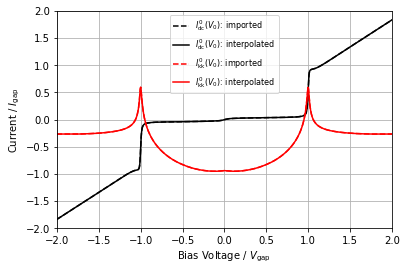

In [4]:
# Load DC I-V data
dciv = qmix.exp.RawData0('eg-230-data/dciv.csv')

# Grab response function
resp = dciv.resp

# Plot
resp.show_current();

## Perform harmonic balance

- Calculate the voltage drop across the junction for each tone/harmonic/bias voltage using harmonic balance.

In [5]:
vj = qmix.harmonic_balance.harmonic_balance(cct, resp, num_b)

Running harmonic balance:
 - 3 tone(s) and 1 harmonic(s)
 - 7 calls to the tunneling current function per iteration
Estimated time:
 - time per iteration:    2.04 s /   0.03 min /  0.00 hrs
 - max time:             20.43 s /   0.34 min /  0.01 hrs
Error after 0 iteration(s):
	f:1.0, p:1,   med. r.error:     0.870,   max r.error:     1.808,     0.0 % complete
	f:2.0, p:1,   med. r.error:     0.854,   max r.error:     1.656,     0.0 % complete
	f:3.0, p:1,   med. r.error: 99999.000,   max r.error: 99999.000,     0.0 % complete
Calculating inverse Jacobian |--------------------| 100.0% Complete
Applying correction
Error after 1 iteration(s):
	f:1.0, p:1,   med. r.error:     0.014,   max r.error:     0.195,     0.0 % complete
	f:2.0, p:1,   med. r.error:     0.046,   max r.error:     0.361,     0.0 % complete
	f:3.0, p:1,   med. r.error:     0.335,   max r.error:    89.688,     0.0 % complete
Calculating inverse Jacobian |--------------------| 100.0% Complete
Applying correction
Error afte

## Calculate tunnelling currents
- ``idc`` is the DC tunneling current
- ``ilo`` is the AC tunneling current at the LO frequency
- ``iif`` is the AC tunneling current at the IF frequency

In [6]:
idc, ilo, iif = qmix.qtcurrent.qtcurrent_std(vj, cct, resp, num_b=num_b)

## Plot the pumped I-V curve

In [7]:
# Convert normalized values to given units
vmv = vgap / sc.milli 
ima = igap / sc.milli 
iua = igap / sc.micro
iua = igap / sc.micro

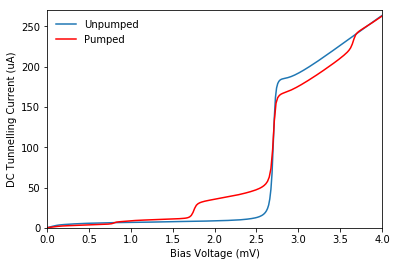

In [8]:
fig, ax1 = plt.subplots()

ax1.plot(resp.voltage*vmv, resp.current*iua, label='Unpumped')
ax1.plot(cct.vb*vmv, idc*iua, 'r', label='Pumped')
ax1.set(xlabel='Bias Voltage (mV)', xlim=(0,4))
ax1.set(ylabel='DC Tunnelling Current (uA)', ylim=(0,270))
ax1.legend(frameon=False);

### Plot gain

In [9]:
# Available power from upper sideband (USB)
pusb = cct.available_power(2)

# Power delivered to load
rload = cct.zt[3,1].real*rn
pload = 0.5 * np.abs(iif*igap) ** 2 * rload

# Gain
gain = pload / pusb

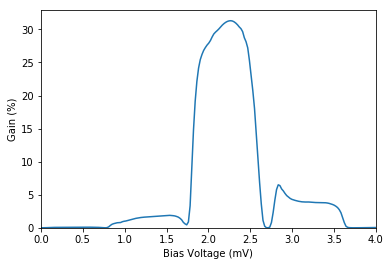

In [10]:
fig, ax2 = plt.subplots()

ax2.plot(cct.vb*vmv, gain*100)
ax2.set(xlabel='Bias Voltage (mV)', xlim=(0,4))
ax2.set(ylabel=r'Gain (%)')
ax2.set_ylim(bottom=0);